In [ ]:
import pandas as pd
from pathlib import Path

# Ruta base del proyecto
BASE_DIR = Path("..")

# Carpeta de datos
DATA_DIR = BASE_DIR / "data" / "raw"

# Archivos esperados
train_tx_path = DATA_DIR / "train_transaction.csv"
train_id_path = DATA_DIR / "train_identity.csv"

assert train_tx_path.exists(), "No se encontró train_transaction.csv en data/raw/"
assert train_id_path.exists(), "No se encontró train_identity.csv en data/raw/"

# Cargar datos
train_tx = pd.read_csv(train_tx_path)
train_id = pd.read_csv(train_id_path)

print("train_transaction shape:", train_tx.shape)
print("train_identity shape:", train_id.shape)

train_tx.head(3)

TX exists: True C:\Users\sebas\OneDrive\Desktop\Proyecto Chatbot\Fraudes\train_transaction.csv
ID exists: True C:\Users\sebas\OneDrive\Desktop\Proyecto Chatbot\Fraudes\train_identity.csv
train_transaction shape: (590540, 394)
train_identity shape: (144233, 41)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
JOIN_KEY = "TransactionID"
TARGET = "isFraud"
TIME_COL = "TransactionDT"

df = train_tx.merge(train_id, on=JOIN_KEY, how="left")

print("merged shape:", df.shape)
print("target in df:", TARGET in df.columns)
print("time col in df:", TIME_COL in df.columns)

# % de fraudes
fraud_rate = df[TARGET].mean()
print(f"Tasa de fraude: {fraud_rate:.4%}")


merged shape: (590540, 434)
target in df: True
time col in df: True
Tasa de fraude: 3.4990%


In [6]:
valid_size = 0.2

df_sorted = df.sort_values(TIME_COL).reset_index(drop=True)
cut = int(len(df_sorted) * (1 - valid_size))

df_train = df_sorted.iloc[:cut].copy()
df_valid = df_sorted.iloc[cut:].copy()

# check anti-leak temporal
print("Train max DT:", df_train[TIME_COL].max())
print("Valid min DT:", df_valid[TIME_COL].min())

assert df_train[TIME_COL].max() <= df_valid[TIME_COL].min(), "Temporal leak: train uses future timestamps."

print("df_train:", df_train.shape, "df_valid:", df_valid.shape)

# Separar X/y
X_train = df_train.drop(columns=[TARGET])
y_train = df_train[TARGET].astype(int)

X_valid = df_valid.drop(columns=[TARGET])
y_valid = df_valid[TARGET].astype(int)

y_train.value_counts(normalize=True), y_valid.value_counts(normalize=True)


Train max DT: 12192842
Valid min DT: 12192900
df_train: (472432, 434) df_valid: (118108, 434)


(isFraud
 0    0.964865
 1    0.035135
 Name: proportion, dtype: float64,
 isFraud
 0    0.965591
 1    0.034409
 Name: proportion, dtype: float64)

In [7]:
import numpy as np

SECONDS_IN_DAY = 24 * 60 * 60

def add_time_features(df, time_col="TransactionDT"):
    x = df.copy()
    t = x[time_col].astype(float)

    x["dt_day"] = (t // SECONDS_IN_DAY).astype(int)
    x["dt_hour"] = ((t % SECONDS_IN_DAY) // 3600).astype(int)
    x["is_night"] = x["dt_hour"].between(0, 6).astype(int)

    return x

X_train_tf = add_time_features(X_train)
X_valid_tf = add_time_features(X_valid)

X_train_tf[["dt_day", "dt_hour", "is_night"]].describe()

,dt_day,dt_hour,is_night
count,472432.000000,472432.000000,472432.000000
mean,65.560443,13.815074,0.259115
std,41.202225,7.671863,0.438149
min,1.000000,0.000000,0.000000
25%,26.000000,6.000000,0.000000
50%,64.000000,16.000000,0.000000
75%,101.000000,20.000000,1.000000
max,141.000000,23.000000,1.000000


In [8]:
def add_missingness_features(df):
    x = df.copy()
    x["n_missing_row"] = x.isna().sum(axis=1).astype(int)
    return x

X_train_tf = add_missingness_features(X_train_tf)
X_valid_tf = add_missingness_features(X_valid_tf)

X_train_tf["n_missing_row"].describe()

count    472432.000000
mean        195.610069
std          49.992147
min          26.000000
25%         208.000000
50%         212.000000
75%         229.000000
max         332.000000
Name: n_missing_row, dtype: float64

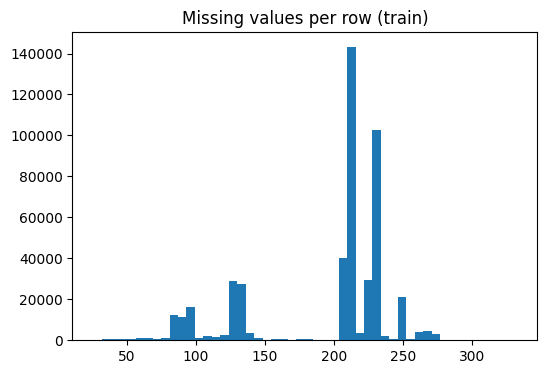

isFraud,0,1
dt_hour,,
"(-0.023, 3.833]",0.966073,0.033927
"(3.833, 7.667]",0.935754,0.064246
"(7.667, 11.5]",0.931341,0.068659
"(11.5, 15.333]",0.975292,0.024708
"(15.333, 19.167]",0.967164,0.032836
"(19.167, 23.0]",0.965235,0.034765


In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(X_train_tf["n_missing_row"], bins=50)
plt.title("Missing values per row (train)")
plt.show()

pd.crosstab(
    pd.cut(X_train_tf["dt_hour"], bins=6),
    y_train,
    normalize="index"
)


In [10]:
BASE_FEATURES = ["TransactionAmt", "dt_hour", "is_night", "n_missing_row"]

# puede que TransactionAmt no exista en identity, check:
BASE_FEATURES = [c for c in BASE_FEATURES if c in X_train_tf.columns]

Xtr_base = X_train_tf[BASE_FEATURES].fillna(-1)
Xva_base = X_valid_tf[BASE_FEATURES].fillna(-1)

BASE_FEATURES


['TransactionAmt', 'dt_hour', 'is_night', 'n_missing_row']

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score

lr = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

lr.fit(Xtr_base, y_train)

p_valid_lr = lr.predict_proba(Xva_base)[:, 1]

pr_auc_lr = average_precision_score(y_valid, p_valid_lr)
pr_auc_lr

0.08338739550770383

In [13]:
import numpy as np
import pandas as pd

def crear_agregaciones_por_grupo(
    X_entrenamiento: pd.DataFrame,
    X_validacion: pd.DataFrame,
    columnas_grupo: list,
    columna_monto: str = "TransactionAmt"
):
    """
    Crea features agregadas por grupo usando SOLO el set de entrenamiento
    (para evitar leakage), y luego las aplica a entrenamiento y validación.

    Agregaciones:
    - conteo de transacciones por grupo
    - promedio y desviación estándar del monto por grupo
    - ratio monto / promedio_monto_grupo
    """

    X_train_nuevo = X_entrenamiento.copy()
    X_valid_nuevo = X_validacion.copy()

    for col_grupo in columnas_grupo:
        if col_grupo not in X_train_nuevo.columns:
            print(f"⚠️ Columna '{col_grupo}' no existe. Se omite.")
            continue

        # Conteo por grupo en entrenamiento
        conteos = X_train_nuevo.groupby(col_grupo).size()
        X_train_nuevo[f"grupo_{col_grupo}_conteo"] = X_train_nuevo[col_grupo].map(conteos).fillna(0).astype(int)
        X_valid_nuevo[f"grupo_{col_grupo}_conteo"] = X_valid_nuevo[col_grupo].map(conteos).fillna(0).astype(int)

        # Si existe columna de monto, agregamos stats por grupo
        if columna_monto in X_train_nuevo.columns:
            promedio_monto = X_train_nuevo.groupby(col_grupo)[columna_monto].mean()
            std_monto = X_train_nuevo.groupby(col_grupo)[columna_monto].std()

            X_train_nuevo[f"grupo_{col_grupo}_monto_promedio"] = X_train_nuevo[col_grupo].map(promedio_monto)
            X_valid_nuevo[f"grupo_{col_grupo}_monto_promedio"] = X_valid_nuevo[col_grupo].map(promedio_monto)

            X_train_nuevo[f"grupo_{col_grupo}_monto_std"] = X_train_nuevo[col_grupo].map(std_monto)
            X_valid_nuevo[f"grupo_{col_grupo}_monto_std"] = X_valid_nuevo[col_grupo].map(std_monto)

            # Ratio: monto / promedio del grupo (robusto con epsilon)
            epsilon = 1e-9
            X_train_nuevo[f"grupo_{col_grupo}_monto_ratio"] = (
                X_train_nuevo[columna_monto] / (X_train_nuevo[f"grupo_{col_grupo}_monto_promedio"] + epsilon)
            )
            X_valid_nuevo[f"grupo_{col_grupo}_monto_ratio"] = (
                X_valid_nuevo[columna_monto] / (X_valid_nuevo[f"grupo_{col_grupo}_monto_promedio"] + epsilon)
            )

    # Reemplazos básicos para evitar inf/nan por divisiones o std inexistente
    X_train_nuevo = X_train_nuevo.replace([np.inf, -np.inf], np.nan).fillna(-1)
    X_valid_nuevo = X_valid_nuevo.replace([np.inf, -np.inf], np.nan).fillna(-1)

    return X_train_nuevo, X_valid_nuevo


In [14]:
columnas_grupo = ["card1", "addr1", "P_emaildomain", "ProductCD"]

X_train_ag, X_valid_ag = crear_agregaciones_por_grupo(
    X_entrenamiento=X_train_tf,
    X_validacion=X_valid_tf,
    columnas_grupo=columnas_grupo,
    columna_monto="TransactionAmt"
)

X_train_ag.shape, X_valid_ag.shape

((472432, 453), (118108, 453))

In [15]:
# columnas base (de antes)
columnas_base = ["TransactionAmt", "dt_hour", "is_night", "n_missing_row"]
columnas_base = [c for c in columnas_base if c in X_train_ag.columns]

# columnas nuevas agregadas (todas las que empiezan con "grupo_")
columnas_agregadas = [c for c in X_train_ag.columns if c.startswith("grupo_")]

# Para no explotar, probamos con base + agregadas
columnas_modelo = columnas_base + columnas_agregadas

Xtr_modelo = X_train_ag[columnas_modelo].copy()
Xva_modelo = X_valid_ag[columnas_modelo].copy()

Xtr_modelo = Xtr_modelo.fillna(-1)
Xva_modelo = Xva_modelo.fillna(-1)

len(columnas_modelo), columnas_modelo[:10]


(20,
 ['TransactionAmt',
  'dt_hour',
  'is_night',
  'n_missing_row',
  'grupo_card1_conteo',
  'grupo_card1_monto_promedio',
  'grupo_card1_monto_std',
  'grupo_card1_monto_ratio',
  'grupo_addr1_conteo',
  'grupo_addr1_monto_promedio'])

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score

modelo_logistico = LogisticRegression(
    max_iter=3000,
    class_weight="balanced"
)

modelo_logistico.fit(Xtr_modelo, y_train)

prob_validacion = modelo_logistico.predict_proba(Xva_modelo)[:, 1]
pr_auc_logistico = average_precision_score(y_valid, prob_validacion)

print(f"PR-AUC: {pr_auc_logistico:.4f}  ({pr_auc_logistico*100:.2f}%)")

PR-AUC: 0.0889  (8.89%)


c:\Users\sebas\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 3000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=3000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [20]:
import lightgbm as lgb
from sklearn.metrics import average_precision_score

# Datos para LGBM
X_entrenamiento = Xtr_modelo.copy()
X_validacion = Xva_modelo.copy()

y_entrenamiento = y_train
y_validacion = y_valid

# LightGBM acepta NaN, pero nosotros ya rellenamos con -1.
# Igual dejamos esto por si acaso.
X_entrenamiento = X_entrenamiento.replace([float("inf"), float("-inf")], None).fillna(-1)
X_validacion = X_validacion.replace([float("inf"), float("-inf")], None).fillna(-1)

# Peso por desbalance (recomendado)
cantidad_positivos = int(y_entrenamiento.sum())
cantidad_negativos = int(len(y_entrenamiento) - cantidad_positivos)
peso_positivo = cantidad_negativos / max(cantidad_positivos, 1)

parametros_lgbm = {
    "objective": "binary",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "min_data_in_leaf": 80,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "lambda_l2": 1.0,
    "max_depth": -1,
    "metric": "auc",                 # métrica interna (no es la final)
    "scale_pos_weight": peso_positivo,
    "verbosity": -1,
}

datos_entrenamiento = lgb.Dataset(X_entrenamiento, label=y_entrenamiento)
datos_validacion = lgb.Dataset(X_validacion, label=y_validacion, reference=datos_entrenamiento)

modelo_lgbm = lgb.train(
    params=parametros_lgbm,
    train_set=datos_entrenamiento,
    valid_sets=[datos_entrenamiento, datos_validacion],
    valid_names=["entrenamiento", "validacion"],
    num_boost_round=5000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=200),
        lgb.log_evaluation(period=200),
    ],
)

# Probabilidades (score) en validación
prob_valid_lgbm = modelo_lgbm.predict(X_validacion, num_iteration=modelo_lgbm.best_iteration)

# PR-AUC final
pr_auc_lgbm = average_precision_score(y_validacion, prob_valid_lgbm)
print(f"PR-AUC LightGBM: {pr_auc_lgbm:.6f} ({pr_auc_lgbm*100:.2f}%)")


Training until validation scores don't improve for 200 rounds
[200]	entrenamiento's auc: 0.92623	validacion's auc: 0.829219
[400]	entrenamiento's auc: 0.952884	validacion's auc: 0.832667
[600]	entrenamiento's auc: 0.967196	validacion's auc: 0.832501
Early stopping, best iteration is:
[420]	entrenamiento's auc: 0.954749	validacion's auc: 0.83313
PR-AUC LightGBM: 0.279579 (27.96%)


In [21]:
import numpy as np

def precision_recall_en_top_k(y_real, score, k):
    y_real = np.asarray(y_real)
    score = np.asarray(score)

    n = len(y_real)
    m = max(1, int(n * k))

    idx = np.argsort(-score)[:m]
    vp = int(y_real[idx].sum())
    fp = int(m - vp)

    precision = vp / m
    recall = vp / max(int(y_real.sum()), 1)

    return precision, recall, vp, fp

for k in [0.001, 0.002, 0.005, 0.01, 0.02]:
    precision, recall, vp, fp = precision_recall_en_top_k(y_valid, prob_valid_lgbm, k)
    print(f"Top {k*100:.1f}% | Precisión: {precision*100:.2f}% | Recall: {recall*100:.2f}% | VP: {vp} | FP: {fp}")


Top 0.1% | Precisión: 79.66% | Recall: 2.31% | VP: 94 | FP: 24
Top 0.2% | Precisión: 66.53% | Recall: 3.86% | VP: 157 | FP: 79
Top 0.5% | Precisión: 55.59% | Recall: 8.07% | VP: 328 | FP: 262
Top 1.0% | Precisión: 51.23% | Recall: 14.89% | VP: 605 | FP: 576
Top 2.0% | Precisión: 44.45% | Recall: 25.84% | VP: 1050 | FP: 1312


## ✅ Conclusiones del ranking y la política de revisión

Los resultados obtenidos con el modelo **LightGBM** muestran que es posible  
**priorizar revisiones de forma altamente eficiente** en un contexto de fraude
fuertemente desbalanceado (≈ **3.5%** de fraude).

### 🔍 Resultados clave

- **Top 0.1% de transacciones**
  - Precisión cercana al **80%**
  - Permite aplicar **acciones automáticas o bloqueos** con bajo riesgo de error

- **Top 1% de transacciones**
  - Precisión superior al **50%**
  - Captura cerca del **15% del fraude total**
  - Representa una mejora de más de **14 veces** respecto a una selección aleatoria


### ⚖️ Trade-off operativo

A medida que aumenta el porcentaje de transacciones revisadas:

- 📉 **La precisión disminuye** (se revisan más casos no fraudulentos)
- 📈 **El recall aumenta** (se captura una mayor proporción del fraude total)

Este comportamiento es esperado y refleja el compromiso natural entre
**eficiencia operativa** y **cobertura del fraude**.


### 🎯 Conclusión práctica

El modelo **ordena correctamente las transacciones por nivel de riesgo**, lo que
permite definir **políticas de revisión flexibles**, ajustadas a la capacidad
operativa y al costo asociado al fraude no detectado.

En este sentido, el modelo no solo presenta un buen desempeño predictivo,
sino que entrega **valor accionable**, habilitando decisiones informadas en un
escenario productivo real.

In [23]:
from sklearn.base import BaseEstimator, ClassifierMixin

class LightGBMWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, modelo_lgbm):
        self.modelo_lgbm = modelo_lgbm

    def fit(self, X, y=None):
        # El modelo ya está entrenado
        return self

    def predict_proba(self, X):
        prob = self.modelo_lgbm.predict(X, num_iteration=self.modelo_lgbm.best_iteration)
        prob = np.clip(prob, 1e-9, 1 - 1e-9)
        return np.vstack([1 - prob, prob]).T


In [25]:
# Asegurar orden temporal en la validación
valid_df = X_validacion.copy()
valid_df["__y__"] = y_validacion.values

# Si existe TransactionDT, lo usamos para split temporal dentro de validación
if "TransactionDT" in valid_df.columns:
    valid_df = valid_df.sort_values("TransactionDT").reset_index(drop=True)

# 50% calibración, 50% prueba (puedes ajustar 0.6/0.4 si quieres)
fraccion_calibracion = 0.5
corte = int(len(valid_df) * fraccion_calibracion)

valid_cal = valid_df.iloc[:corte].copy()
valid_test = valid_df.iloc[corte:].copy()

X_valid_cal = valid_cal.drop(columns=["__y__"])
y_valid_cal = valid_cal["__y__"].astype(int)

X_valid_test = valid_test.drop(columns=["__y__"])
y_valid_test = valid_test["__y__"].astype(int)

len(X_valid_cal), len(X_valid_test), y_valid_cal.mean(), y_valid_test.mean()


(59054,
 59054,
 np.float64(0.03134419345006265),
 np.float64(0.03747417617773563))

In [ ]:
# Score sin calibrar (modelo LGBM ya entrenado)
score_cal_sin = modelo_lgbm.predict(X_valid_cal, num_iteration=modelo_lgbm.best_iteration)
score_test_sin = modelo_lgbm.predict(X_valid_test, num_iteration=modelo_lgbm.best_iteration)

In [ ]:
calibrador_sigmoid = LogisticRegression(max_iter=3000, class_weight="balanced")
calibrador_sigmoid.fit(score_cal_sin.reshape(-1, 1), y_valid_cal)

score_test_sigmoid = calibrador_sigmoid.predict_proba(score_test_sin.reshape(-1, 1))[:, 1]

In [ ]:
from sklearn.isotonic import IsotonicRegression

calibrador_isotonic = IsotonicRegression(out_of_bounds="clip")
calibrador_isotonic.fit(score_cal_sin, y_valid_cal)

score_test_isotonic = calibrador_isotonic.transform(score_test_sin)

In [29]:
from sklearn.metrics import average_precision_score

pr_auc_sin = average_precision_score(y_valid_test, score_test_sin)
pr_auc_sig = average_precision_score(y_valid_test, score_test_sigmoid)
pr_auc_iso = average_precision_score(y_valid_test, score_test_isotonic)

print(f"PR-AUC (test) sin calibrar : {pr_auc_sin:.4f}  ({pr_auc_sin*100:.2f}%)")
print(f"PR-AUC (test) sigmoid      : {pr_auc_sig:.4f}  ({pr_auc_sig*100:.2f}%)")
print(f"PR-AUC (test) isotonic     : {pr_auc_iso:.4f}  ({pr_auc_iso*100:.2f}%)")


PR-AUC (test) sin calibrar : 0.2862  (28.62%)
PR-AUC (test) sigmoid      : 0.2862  (28.62%)
PR-AUC (test) isotonic     : 0.2701  (27.01%)


## 🔧 Conclusión sobre la calibración de probabilidades

Se evaluaron dos métodos de calibración sobre el modelo LightGBM: **Sigmoid (Platt scaling)** e **Isotonic regression**, comparándolos contra el score sin calibrar.

Los resultados muestran que:

- La calibración **Sigmoid** mantiene el desempeño en términos de ranking, conservando el mismo PR-AUC que el modelo original.
- La calibración **Isotonic** presenta una disminución del PR-AUC, lo que sugiere un posible sobreajuste en este contexto.
- El modelo sin calibrar ordena correctamente las transacciones, pero sus scores no representan probabilidades confiables.

En base a estos resultados, se selecciona **Sigmoid** como método de calibración final, ya que permite mejorar la interpretabilidad de las probabilidades **sin afectar el ranking**, habilitando una evaluación basada en costos y umbrales de decisión realistas.

In [31]:
COSTO_FRAUDE_NO_DETECTADO = 100.0
COSTO_REVISION = 1.0


def costo_en_top_k(y_real, score, k,
                   costo_fraude=COSTO_FRAUDE_NO_DETECTADO,
                   costo_revision=COSTO_REVISION):
    y_real = np.asarray(y_real)
    score = np.asarray(score)

    n = len(y_real)
    m = max(1, int(n * k))

    idx = np.argsort(-score)[:m]

    # Revisadas
    vp = int(y_real[idx].sum())
    fp = int(m - vp)

    # Fraudes totales
    total_fraudes = int(y_real.sum())

    # Fraudes no detectados
    fn = total_fraudes - vp

    costo_total = (
        m * costo_revision +
        fn * costo_fraude
    )

    return {
        "k": k,
        "revisadas": m,
        "fraudes_detectados": vp,
        "fraudes_no_detectados": fn,
        "precision": vp / m,
        "recall": vp / max(total_fraudes, 1),
        "costo_total": costo_total
    }


In [32]:
ks = [0.001, 0.002, 0.005, 0.01, 0.02, 0.03, 0.05]

resultados = [
    costo_en_top_k(y_valid_test, score_test_sigmoid, k)
    for k in ks
]

df_costos = pd.DataFrame(resultados)
df_costos


,k,revisadas,fraudes_detectados,fraudes_no_detectados,precision,recall,costo_total
0,0.001,59,51,2162,0.864407,0.023046,216259.0
1,0.002,118,83,2130,0.703390,0.037506,213118.0
2,0.005,295,177,2036,0.600000,0.079982,203895.0
3,0.010,590,326,1887,0.552542,0.147311,189290.0
4,0.020,1181,558,1655,0.472481,0.252146,166681.0
5,0.030,1771,698,1515,0.394128,0.315409,153271.0
6,0.050,2952,858,1355,0.290650,0.387709,138452.0


In [34]:
df_costos[[
    "k",
    "revisadas",
    "fraudes_detectados",
    "fraudes_no_detectados",
    "precision",
    "recall",
    "costo_total"
]]

df_costos.sort_values("costo_total")


,k,revisadas,fraudes_detectados,fraudes_no_detectados,precision,recall,costo_total
6,0.050,2952,858,1355,0.290650,0.387709,138452.0
5,0.030,1771,698,1515,0.394128,0.315409,153271.0
4,0.020,1181,558,1655,0.472481,0.252146,166681.0
3,0.010,590,326,1887,0.552542,0.147311,189290.0
2,0.005,295,177,2036,0.600000,0.079982,203895.0
1,0.002,118,83,2130,0.703390,0.037506,213118.0
0,0.001,59,51,2162,0.864407,0.023046,216259.0


## 🏁 Conclusiones finales y política óptima de revisión

El modelo LightGBM calibrado mediante **Sigmoid** permite priorizar de forma
efectiva las transacciones más riesgosas en un contexto de fraude altamente
desbalanceado.

Para conectar el desempeño del modelo con decisiones operativas reales, se definió
una función de costo que considera:

- Un costo bajo asociado a la **revisión manual** de una transacción.
- Un costo significativamente mayor asociado a **no detectar un fraude**.

Bajo esta función de costo, se evaluaron distintas políticas de revisión basadas en
el ranking del modelo. Los resultados muestran que:

- Políticas muy restrictivas (top 0.1% – 1%) logran altas precisiones, pero dejan
  pasar una gran cantidad de fraude, lo que resulta en un costo total elevado.
- Aumentar el porcentaje revisado reduce la cantidad de fraudes no detectados,
  aun cuando la precisión disminuye.
- El **mínimo costo total** se alcanza al revisar aproximadamente el **top 5%**
  de las transacciones más riesgosas, capturando cerca del **39% del fraude total**
  con una mejora sustancial respecto a una selección aleatoria.

En consecuencia, el modelo no solo presenta un buen desempeño predictivo, sino que
habilita la definición de una **estrategia de decisión cuantitativa, realista y
accionable**, alineada con objetivos de negocio y restricciones operativas.

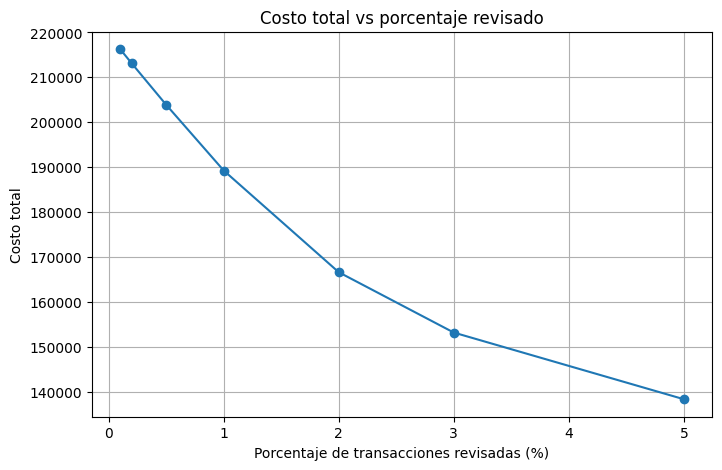

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(df_costos["k"] * 100, df_costos["costo_total"], marker="o")
plt.xlabel("Porcentaje de transacciones revisadas (%)")
plt.ylabel("Costo total")
plt.title("Costo total vs porcentaje revisado")
plt.grid(True)
plt.show()

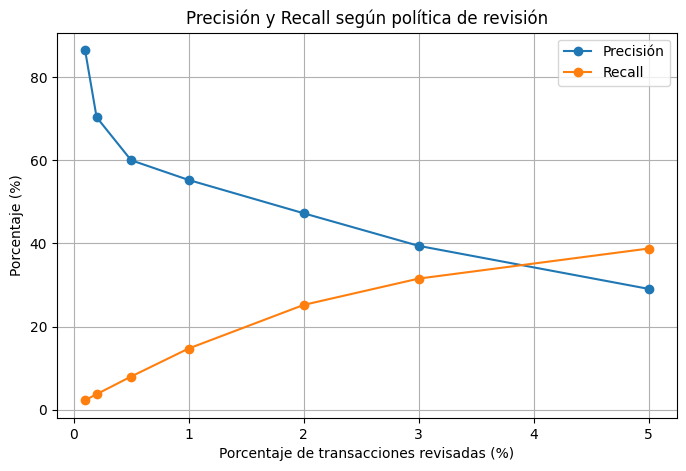

In [37]:
plt.figure(figsize=(8,5))

plt.plot(df_costos["k"] * 100, df_costos["precision"] * 100, label="Precisión", marker="o")
plt.plot(df_costos["k"] * 100, df_costos["recall"] * 100, label="Recall", marker="o")

plt.xlabel("Porcentaje de transacciones revisadas (%)")
plt.ylabel("Porcentaje (%)")
plt.title("Precisión y Recall según política de revisión")
plt.legend()
plt.grid(True)
plt.show()


### 📊 Visualización de la política de revisión

Los gráficos muestran claramente el trade-off entre eficiencia y cobertura.
A medida que aumenta el porcentaje de transacciones revisadas, el recall mejora,
pero la precisión disminuye.

La curva de costo total permite identificar de forma explícita la política
óptima de revisión, evidenciando que el mejor desempeño operativo no coincide
necesariamente con la mayor precisión, sino con el **menor costo total**.

In [35]:
from pathlib import Path
import joblib

ruta_artefactos = Path("reports/artefactos_finales")
ruta_artefactos.mkdir(parents=True, exist_ok=True)

joblib.dump(modelo_lgbm, ruta_artefactos / "modelo_lightgbm.joblib")
joblib.dump(calibrador_sigmoid, ruta_artefactos / "calibrador_sigmoid.joblib")

# Guardamos la política óptima
k_optimo = df_costos.loc[df_costos["costo_total"].idxmin(), "k"]

with open(ruta_artefactos / "politica_revision.txt", "w") as f:
    f.write(f"Politica de revision optima: revisar top {k_optimo*100:.2f}%\n")

print("Artefactos finales guardados en:", ruta_artefactos.resolve())

Artefactos finales guardados en: C:\Users\sebas\OneDrive\Desktop\Proyecto Chatbot\Fraudes\reports\artefactos_finales
